In [26]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree
from sklearn.utils import resample

### Step 1 - Read the file train.csv into Python and print a few rows.
#### (We skip test/train split this time, since kaggle provides us with test data)

In [12]:
df = pd.read_csv('~\\SPICED\\train.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [13]:
X = df.drop('Survived', axis=1)
y = df['Survived']
# train/test splitting

In [14]:
#Checking for missing data
X.count()

PassengerId    891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

### Step 3 - Feature Engineering

In [15]:
# creating total relatives feature
def total_relatives(data):
    new_data = data['SibSp'] + data['Parch']
    return pd.DataFrame(new_data)

In [32]:
fe = ColumnTransformer([
    
    # let's pass the "SibSp", "Parch" and "Pclass" through for the moment
    ('do_nothing', 'passthrough', ['Pclass', 'SibSp', 'Parch']), 
    
    # let's fill the age gaps
    ('fill_gaps', SimpleImputer(strategy='median'), ['Age', 'Fare']),
    
    # let's encode the 'Sex'
    ('encode_sex', OrdinalEncoder(), ['Sex']),
    
    # summing relatived seems to be a stupid idea
    # ('total_relatives', FunctionTransformer(total_relatives), ['SibSp', 'Parch']),
])

In [34]:
# training and applying our Column Transformer
fe.fit(X)
X_trans = fe.transform(X)

In [19]:
X_trans[:3]

array([[ 3.    ,  1.    ,  0.    ,  7.25  , 22.    ,  1.    ],
       [ 1.    ,  1.    ,  0.    , 71.2833, 38.    ,  0.    ],
       [ 3.    ,  0.    ,  0.    ,  7.925 , 26.    ,  0.    ]])

### Step 4 - Decision Tree Trial

In [22]:
m = DecisionTreeClassifier(max_depth=8) #depth should be increased with amount of features increased
m.fit(X_trans, y)

DecisionTreeClassifier(max_depth=8)

In [23]:
round(m.score(X_trans, y), 3)  # --> train accuracy

0.893

[Text(298.4565789473684, 513.4, 'X[5] <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]'),
 Text(163.82072368421052, 453.0, 'X[0] <= 2.5\ngini = 0.383\nsamples = 314\nvalue = [81, 233]'),
 Text(61.67368421052632, 392.6, 'X[4] <= 2.5\ngini = 0.1\nsamples = 170\nvalue = [9, 161]'),
 Text(39.64736842105263, 332.2, 'X[3] <= 88.775\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(30.83684210526316, 271.8, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(48.45789473684211, 271.8, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(83.7, 332.2, 'X[3] <= 28.856\ngini = 0.091\nsamples = 168\nvalue = [8, 160]'),
 Text(66.07894736842105, 271.8, 'X[3] <= 28.231\ngini = 0.182\nsamples = 69\nvalue = [7, 62]'),
 Text(57.26842105263158, 211.39999999999998, 'X[4] <= 56.0\ngini = 0.161\nsamples = 68\nvalue = [6, 62]'),
 Text(35.242105263157896, 151.0, 'X[1] <= 0.5\ngini = 0.14\nsamples = 66\nvalue = [5, 61]'),
 Text(17.621052631578948, 90.59999999999997, 'X[3] <= 13.25\ngini = 0.085\nsamples = 45\

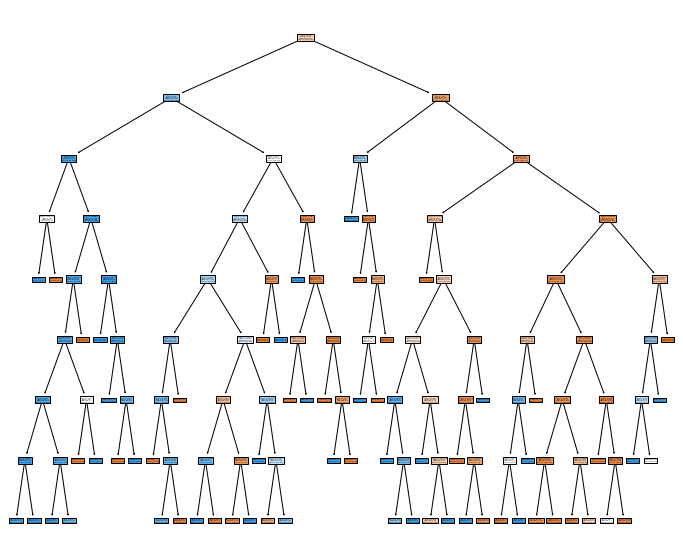

In [25]:
# plotting our tree (just for fun)
plt.figure(figsize=(12, 10))
plot_tree(m, filled=True)

### Step 5 - Bootstraping Validation/Hyperparameters Selection

In [27]:
boots = []
for i in range(1000):
    # Resample the original data to create a "new" dataset
    Xb, yb = resample(X_trans, y)
    
    b = round(0.8 * (Xb.shape[0]))
    
    # Split the data into training and validation set
    Xb_train = Xb[:b]
    yb_train = yb[:b]
    Xb_validation = Xb[b:]
    yb_validation = yb[b:]

    # Fit the model and calculate the validation score
    m.fit(Xb_train, yb_train)
    score = m.score(Xb_validation, yb_validation)
    boots.append(score)
    #print(i, score)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020D5194DB80>]],
      dtype=object)

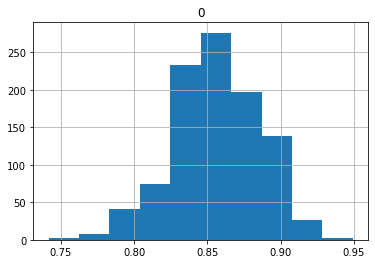

In [28]:
boots_df = pd.DataFrame(boots)
boots_df.hist()

In [131]:
boots_df.describe()

,0
count,1000.000000
mean,0.874993
std,0.029273
min,0.774648
25%,0.859155
50%,0.873239
75%,0.894366
max,0.964789


### Step 6 - Evaluating the Model, Getting result (csv) file

In [35]:
# loading the test data
test = pd.read_csv('~\\SPICED\\test.csv')

# transforming the test data
test_trans = fe.transform(test)

In [38]:
pd.DataFrame({'Survived':m.predict(test_trans)})

,Survived
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [39]:
df_res = pd.DataFrame()
df_res['PassengerId'] = test['PassengerId']
df_res['Survived'] = pd.DataFrame({'Survived':m.predict(test_trans)})['Survived']
#df_res.set_index('PassengerId', inplace=True)

In [40]:
df_res

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [41]:
df_res.to_csv('results_decision_tree.csv', index=False)

Kaggle Results for this model: 0.72248, which is not really good.